# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Features](#Features)
- [Random Forest](#Random-Forest-Regression-Model)
    - [Fastball RHP](#Fastball-RHP)
    - [Fastball LHP](#Fastball-LHP)
    - [Breaking Ball RHP](#Breaking-Ball-RHP)
    - [BreakingBall LHP](#Breaking-Ball-LHP)
    - [Off-Speed RHP](#off-Speed-RHP)
    - [Off-Speed LHP](#Off-Speed-LHP)

# Imports

In [1]:
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from matplotlib.patches import Rectangle

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv('../data/model-pitches-rv.csv', index_col = [0])
data.drop(columns = ['plate_x', 'release_pos_x'], inplace = True)
data.rename(columns = {'pfx_-x': 'pfx_x', 
                       'plate_-x': 'plate_x', 
                       'release_pos_-x': 'release_pos_x'}, 
            inplace = True)

pd.set_option('max_columns', None)
print(data.shape)
data.head()

(705396, 68)


,player_name,p_throws,pitch_type,velo,spin_rate,spin_axis,pfx_x,pfx_z,bauer_units,effective_speed,release_pos_x,release_pos_z,release_extension,release_pos_y,plate_x,plate_z,type,balls,strikes,pitch_count,delta_run_exp,stand,bb_type,description,events,hit_distance_sc,exit_velo,launch_angle,launch_speed_angle,woba_value,woba_denom,xba,xwoba,babip_value,iso_value,at_bat_number,pitch_number,inning,inning_topbot,home_score,away_score,post_home_score,post_away_score,on_1b,on_2b,on_3b,outs_when_up,arm_angle,slot,is_strike,is_ball,final_pitch_ab,out_to_end_inning,home_runs,away_runs,runs,re,re_change,re_end_state,re24,lin_weight_above_avg,lin_weight_above_outs,woba_scale,lin_weights_above_avg_scale,lin_weights_above_outs_scale,woba,wraa_change,rv
0,"Smith, Will",L,FF,92.3,2330.0,148.0,-8.28,16.56,25.243770,92.8,-1.40,6.80,6.5,54.03,0.69,2.83,X,1,2,1-2,-0.073,R,ground_ball,hit_into_play,field_out,13.0,95.2,-13.0,2.0,0.0,1.0,0.174,0.158,0.0,0.0,61,4,9,0,5,0,5,0,0,0,0,2,36.0,1,1,0,1,1,0,0,0,0.11,-0.11,0.00,-0.11,-0.271,0.0,1.209,-0.328,0.0,0.222,-0.152,-0.262
1,"Smith, Will",L,SL,80.6,2254.0,315.0,9.24,5.76,27.965261,81.2,-1.60,6.64,6.4,54.15,0.71,2.62,S,1,1,1-1,-0.027,R,NaN,strike,NaN,108.0,75.3,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,3,9,0,5,0,5,0,0,0,0,2,45.8,2,1,0,0,0,0,0,0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.0,0.300,-0.053,-0.053
2,"Smith, Will",L,CU,75.5,1940.0,328.0,7.80,-6.12,25.695364,75.2,-1.46,6.88,6.2,54.34,0.04,2.46,S,1,0,1-0,-0.020,R,NaN,strike,NaN,157.0,83.5,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,2,9,0,5,0,5,0,0,0,0,2,38.4,1,1,0,0,0,0,0,0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.0,0.356,-0.038,-0.038
3,"Smith, Will",L,CU,75.0,2017.0,330.0,8.28,-8.28,26.893333,74.5,-1.53,6.83,5.9,54.61,-2.10,3.89,B,0,0,0-0,0.016,R,NaN,ball,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,1,9,0,5,0,5,0,0,0,0,2,38.4,1,0,1,0,0,0,0,0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.0,0.314,0.028,0.028
4,"Smith, Will",L,FF,91.2,2281.0,143.0,-7.56,15.36,25.010965,90.9,-1.49,6.66,6.3,54.15,0.31,2.80,X,1,0,1-0,-0.189,L,ground_ball,hit_into_play,field_out,9.0,93.3,-18.0,2.0,0.0,1.0,0.100,0.090,0.0,0.0,60,2,9,0,5,0,5,0,0,0,0,1,36.0,1,1,0,1,0,0,0,0,0.29,-0.18,0.11,-0.18,-0.271,0.0,1.209,-0.328,0.0,0.356,-0.038,-0.218


In [3]:
feldman = pd.read_csv('../data/feldman_d_041922.csv')
feldman.rename(columns = feldman.iloc[3], inplace = True)
feldman.drop(columns = ['Pitch ID', 'Unique ID', 'Device Serial Number'], index = [0, 1, 2, 3, 19], 
             inplace = True)

col_dict = ({'Pitch Type': 'pitch_type',
             'Is Strike': 'is_strike',
             'Strike Zone Side': 'plate_x',
             'Strike Zone Height': 'plate_z',
             'Velocity': 'velo',
             'Total Spin': 'spin_rate',
             'True Spin (release)': 'true_spin',
             'Spin Efficiency (release)': 'spin_eff',
             'Spin Direction': 'spin_dir',
             'Spin Confidence': 'spin_confidence',
             'HB (spin)': 'pfx_x',
             'VB (spin)': 'pfx_z',
             'Release Side': 'release_pos_x',
             'Release Height': 'release_pos_z',
             'Horizontal Angle': 'horizontal_angle',
             'Release Angle': 'release_angle',
             'Gyro Degree (deg)': 'gyro_deg'
              })

feldman.rename(columns = col_dict, inplace = True)
feldman_cols = feldman.columns.drop('pitch_type')
feldman[feldman_cols] = feldman[feldman_cols].apply(pd.to_numeric, errors='ignore')
feldman = feldman.round(1)
print(feldman.shape)
feldman.head()

(62, 19)


,No,Date,pitch_type,is_strike,plate_x,plate_z,velo,spin_rate,true_spin,spin_eff,spin_dir,spin_confidence,pfx_z,pfx_x,horizontal_angle,release_angle,release_pos_z,release_pos_x,gyro_deg
4,1,Tue Apr 19 2022 7:48:11 PM,Fastball,N,11.3,17.4,89.2,2114.7,1999.0,94.5,1:8,1.0,15.9,10.7,-2.2,-2.3,4.9,1.9,19.0
5,2,Tue Apr 19 2022 7:48:22 PM,Fastball,N,23.5,37.8,89.4,2278.9,2174.5,95.4,1:6,0.9,17.2,11.4,-1.5,-0.7,4.9,2.0,17.4
6,3,Tue Apr 19 2022 7:48:31 PM,Fastball,Y,-1.8,30.7,89.5,2327.2,2176.9,93.5,0:52,0.9,17.8,8.7,-2.6,-1.5,4.7,1.7,20.7
7,4,Tue Apr 19 2022 7:49:15 PM,Fastball,Y,3.4,39.0,91.1,2455.1,2165.9,88.2,0:48,0.9,18.6,8.3,-2.0,-0.5,4.8,1.8,28.1
8,5,Tue Apr 19 2022 7:50:16 PM,Fastball,Y,-2.2,26.6,91.6,2266.1,2032.1,89.7,0:54,0.9,16.4,8.3,-2.8,-1.7,4.7,1.8,26.3


In [4]:
feldman.pitch_type.value_counts()

Fastball           30
Slider             14
ChangeUp           11
CurveBall           6
TwoSeamFastball     1
Name: pitch_type, dtype: int64

In [5]:
steinfort = pd.read_csv('../data/steinfort_a_041922.csv')
steinfort.rename(columns = steinfort.iloc[3], inplace = True)
steinfort.drop(columns = ['Pitch ID', 'Unique ID', 
                          'Device Serial Number'], 
               index = [0, 1, 2, 3, 4, 5, 10, 
                        11, 12, 26, 34, 76, 77], inplace = True)

steinfort.rename(columns = col_dict, inplace = True)
steinfort_cols = steinfort.columns.drop('pitch_type')
steinfort[steinfort_cols] = steinfort[steinfort_cols].apply(pd.to_numeric, errors = 'coerce')
print(steinfort.shape)
steinfort.head()

(83, 19)


,No,Date,pitch_type,is_strike,plate_x,plate_z,velo,spin_rate,true_spin,spin_eff,spin_dir,spin_confidence,pfx_z,pfx_x,horizontal_angle,release_angle,release_pos_z,release_pos_x,gyro_deg
6,3,NaN,Fastball,NaN,-3.63,14.43,88.00,2051.6,2005.3,97.7,NaN,0.8,17.0,10.1,-2.08,-3.80,5.89,1.30,12.19
7,4,NaN,Fastball,NaN,26.52,44.20,88.54,197.6,107.1,54.2,NaN,0.7,1.0,1.9,-0.36,-1.34,6.06,1.42,-57.17
8,5,NaN,Fastball,NaN,15.21,4.25,87.44,2168.2,2154.7,99.4,NaN,0.9,18.7,8.9,-1.16,-4.48,5.97,1.35,6.40
9,6,NaN,Fastball,NaN,-3.46,15.44,88.28,2108.9,2018.5,95.7,NaN,1.0,16.5,10.4,-2.53,-3.73,6.12,1.10,16.84
13,10,NaN,Fastball,NaN,-7.48,39.77,83.35,2300.3,1111.1,48.3,NaN,0.9,10.1,2.4,-2.21,-0.28,5.85,1.33,61.12


In [6]:
steinfort.pitch_type.value_counts()

Fastball     38
Cutter       17
CurveBall    16
Splitter     11
-             1
Name: pitch_type, dtype: int64

### Features

**Independent Variables:** Velocity, Spin Rate, HB, VB, Release Side, Release Height, Arm Angle, Release Extension

**Dependent Variable:** Run Value

In [7]:
features = data[['player_name', 'p_throws', 'pitch_type', 'velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                 'release_pos_x', 'release_pos_z', 'rv']]
feldman_features = feldman[['pitch_type', 'velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                            'release_pos_x', 'release_pos_z']]
steinfort_features = steinfort[['pitch_type', 'velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                'release_pos_x', 'release_pos_z']]

In [8]:
fastball = features[features['pitch_type'].isin(['FF', 'FC', 'SI'])]

feldman_fb = feldman_features[feldman_features['pitch_type'].isin(['Fastball', 'TwoSeamFastball'])]
steinfort_fb = steinfort_features[steinfort_features['pitch_type'].isin(['Fastball', 'Cutter'])]

breaking_ball = features[features['pitch_type'].isin(['SL', 'CU', 'KC'])]

feldman_bb = feldman_features[feldman_features['pitch_type'].isin(['Slider', 'CurveBall'])]
steinfort_bb = steinfort_features[steinfort_features['pitch_type'].isin(['CurveBall'])]

offspeed = features[features['pitch_type'].isin(['CH', 'FS'])]

feldman_os = feldman_features[feldman_features['pitch_type'].isin(['ChangeUp'])]
steinfort_os = steinfort_features[steinfort_features['pitch_type'].isin(['Splitter'])]

rhp = features.loc[features['p_throws'] == 'R']
lhp = features.loc[features['p_throws'] == 'L']
rhp_fb = fastball.loc[fastball['p_throws'] == 'R']
lhp_fb = fastball.loc[fastball['p_throws'] == 'L']
rhp_bb = breaking_ball.loc[breaking_ball['p_throws'] == 'R']
lhp_bb = breaking_ball.loc[breaking_ball['p_throws'] == 'L']
rhp_os = offspeed.loc[offspeed['p_throws'] == 'R']
lhp_os = offspeed.loc[offspeed['p_throws'] == 'L']

# Random Forest Regression Model

## Fastball RHP Grouped

#### 4-Seam, Cutter, Sinker

In [9]:
print('Baseline RHP Fastball RunValue Accuracy Score:', round(rhp_fb.rv.mean(), 2))

Baseline RHP Fastball RunValue Accuracy Score: -0.02


In [10]:
features_fb_r = rhp_fb.select_dtypes([np.number])
X = features_fb_r.drop(columns = ['rv'])
y = features_fb_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_fastball_r = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Score:', round((metrics.r2_score(y_test, pred_fastball_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fastball_r)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_fastball_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Score: -0.04
Test RMSE: 0.282
Test MAE: 0.159 

R2 Score: 0.632
RMSE: 0.168
MAE: 0.085


In [11]:
rhp_fb['xRV'] = pred
rhp_fb['xRV'] = round(rhp_fb['xRV'], 3)
rhp_fb['FF_count'] = [1 if x == 'FF' else 0 for x in rhp_fb['pitch_type']]
rhp_fb['SI_count'] = [1 if x == 'SI' else 0 for x in rhp_fb['pitch_type']]
rhp_fb['FC_count'] = [1 if x == 'FC' else 0 for x in rhp_fb['pitch_type']]

fb_bucket_feldman = rhp_fb.loc[(rhp_fb['velo'] >= 88.9) & (rhp_fb['velo'] <= 93.1)]
fb_bucket_steinfort = rhp_fb.loc[(rhp_fb['velo'] >= 82.81) & (rhp_fb['velo'] <= 94.09)]

rhp_fb.xRV.describe()

count    283224.000000
mean         -0.019230
std           0.157347
min          -1.329000
25%          -0.061000
50%          -0.022000
75%           0.018000
max           2.309000
Name: xRV, dtype: float64

### xRV Table

Velocity, Spin Rate, HB, VB, Release Side, Release Height, Arm Angle, Release Extension

In [12]:
features_feldman_fb = feldman_fb.select_dtypes([np.number])
pred_feldman_fb = rf.predict(features_feldman_fb)
feldman_fb['xRV'] = pred_feldman_fb

print(feldman_fb.shape)
feldman_fb.sort_values(by = 'xRV').head()

(31, 8)


,pitch_type,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,xRV
35,Fastball,91.0,1161.1,0.9,14.3,2.2,4.4,-0.12268
15,Fastball,92.2,2259.2,8.6,16.9,1.5,4.7,-0.11510
14,Fastball,91.7,2267.0,8.7,16.9,1.6,4.8,-0.10239
16,Fastball,92.1,2303.4,8.3,16.1,1.5,5.0,-0.10138
12,Fastball,92.1,2295.3,8.3,17.0,1.5,4.8,-0.09158


In [13]:
feldman_fb.velo.min(), feldman_fb.velo.max()

(89.2, 92.8)

In [14]:
feldman_fb.describe()

,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,xRV
count,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,90.964516,2261.490323,8.458065,16.761290,1.551613,4.887097,0.013483
std,0.954131,218.506438,1.660075,0.761436,0.230754,0.149982,0.085418
min,89.200000,1161.100000,0.900000,14.300000,1.200000,4.400000,-0.122680
25%,90.500000,2266.700000,8.300000,16.400000,1.400000,4.800000,-0.032340
50%,91.000000,2291.900000,8.500000,16.900000,1.500000,4.900000,-0.001890
75%,91.650000,2328.800000,8.700000,17.150000,1.650000,5.000000,0.075745
max,92.800000,2455.100000,11.400000,18.600000,2.200000,5.100000,0.202870


In [15]:
features_steinfort_fb = steinfort_fb.select_dtypes([np.number])
pred_steinfort_fb = rf.predict(features_steinfort_fb)
steinfort_fb['xRV'] = pred_steinfort_fb
print(steinfort_fb.shape)
steinfort_fb.sort_values(by = 'xRV').head()

(55, 8)


,pitch_type,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,xRV
18,Cutter,83.30,718.8,6.5,6.0,1.42,5.82,-0.10629
27,Fastball,91.57,2178.2,11.9,16.4,1.24,5.83,-0.07553
7,Fastball,88.54,197.6,1.9,1.0,1.42,6.06,-0.07354
19,Cutter,84.79,2288.6,-1.5,6.3,1.26,5.77,-0.07146
8,Fastball,87.44,2168.2,8.9,18.7,1.35,5.97,-0.07076


In [17]:
steinfort_fb.velo.min(), steinfort_fb.velo.max()

(82.81, 94.09)

In [19]:
steinfort_fb.describe()

,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,xRV
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,89.169636,2206.060000,6.363636,15.041818,1.261091,5.942000,0.005205
std,3.170199,373.552703,5.290150,4.922236,0.127478,0.212963,0.047513
min,82.810000,197.600000,-18.500000,1.000000,1.010000,5.010000,-0.106290
25%,86.350000,2196.600000,2.700000,11.900000,1.165000,5.890000,-0.025045
50%,89.670000,2312.500000,7.600000,17.000000,1.260000,5.970000,0.007410
75%,91.720000,2358.950000,10.400000,18.800000,1.330000,6.040000,0.035910
max,94.090000,2449.800000,11.900000,19.800000,1.670000,6.260000,0.116030


### RHP Fastball xRV by HB & VB

RHP Fastball Avg xRunValue: -0.02


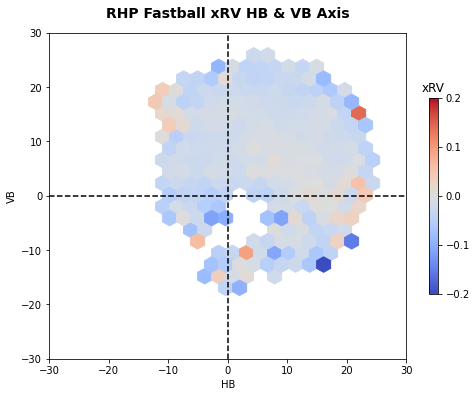

In [21]:
plt.figure(figsize = (8, 6))
plt.hexbin(rhp_fb['pfx_x'], rhp_fb['pfx_z'], C = rhp_fb['xRV'], cmap = 'coolwarm', mincnt = 5, gridsize = 20)
cb = plt.colorbar(ticks = [-.2, -.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Fastball xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)
print('RHP Fastball Avg xRunValue:', round(rhp_fb.xRV.mean(), 2))

### Feldman Fastball

RHP Fastball Avg xRunValue 89-93 mph: -0.01
Feldman Fastball Avg xRunValue 89-93 mph: 0.01


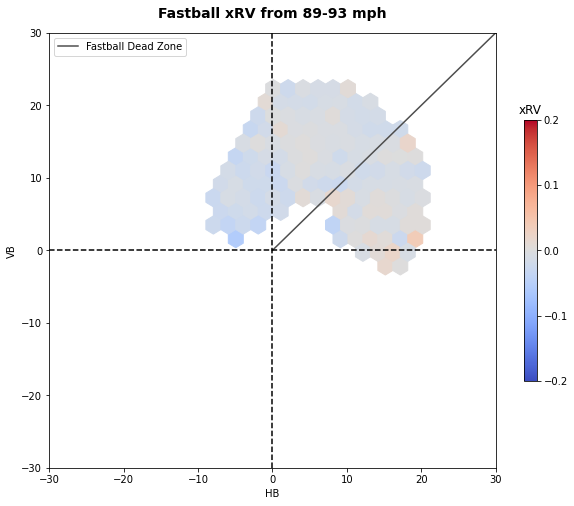

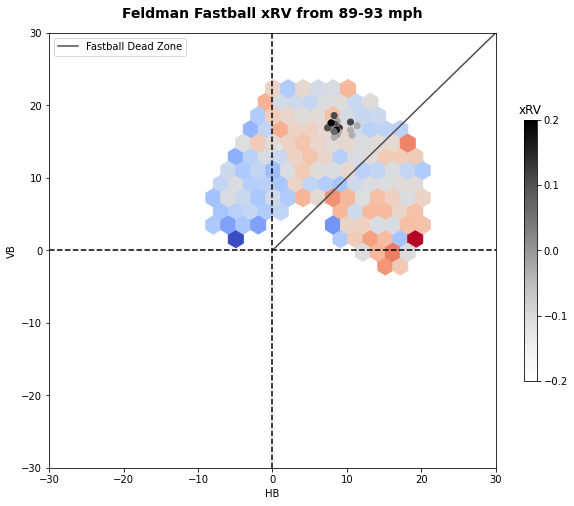

In [23]:
plt.figure(figsize = (10, 8))
plt.hexbin(fb_bucket_feldman['pfx_x'], fb_bucket_feldman['pfx_z'], C = fb_bucket_feldman['xRV'], 
                cmap = 'coolwarm', mincnt = 75, gridsize = 20)
plt.plot([0, 30], [0, 30], ls="-", c=".3", label = 'Fastball Dead Zone')
cb = plt.colorbar(ticks = [-.2, -.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--'), plt.legend()
plt.title('Fastball xRV from 89-93 mph', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Fastball Avg xRunValue 89-93 mph:', round(fb_bucket_feldman.xRV.mean(), 2))

plt.figure(figsize = (10, 8))
plt.hexbin(fb_bucket_feldman['pfx_x'], fb_bucket_feldman['pfx_z'], C = fb_bucket_feldman['xRV'], 
                cmap = 'coolwarm', mincnt = 75, gridsize = 20)
plt.scatter(feldman_fb['pfx_x'], feldman_fb['pfx_z'], c = feldman_fb['xRV'], cmap = 'Greys')
plt.plot([0, 30], [0, 30], ls="-", c=".3", label = 'Fastball Dead Zone')
cb = plt.colorbar(ticks = [-.2, -.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--'), plt.legend()
plt.title('Feldman Fastball xRV from 89-93 mph', fontsize = 14, fontweight = 'bold', pad = 15);
print('Feldman Fastball Avg xRunValue 89-93 mph:', (round(feldman_fb.xRV.mean(), 2)))

### Steinfort Fastball

RHP Fastball Avg xRunValue 89-93 mph: -0.01
Steinfort Fastball Avg xRunValue 82-94 mph: 0.01


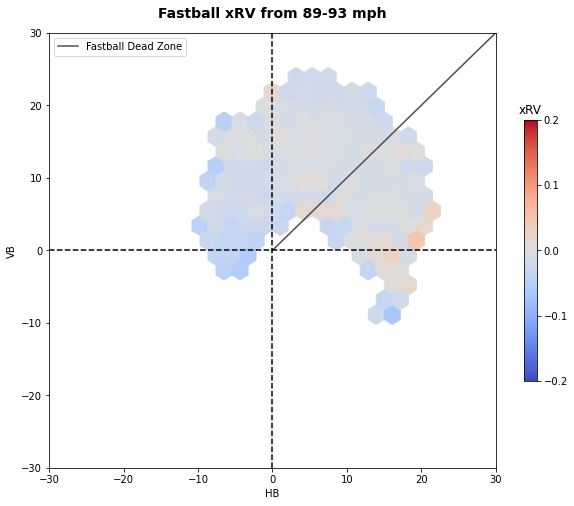

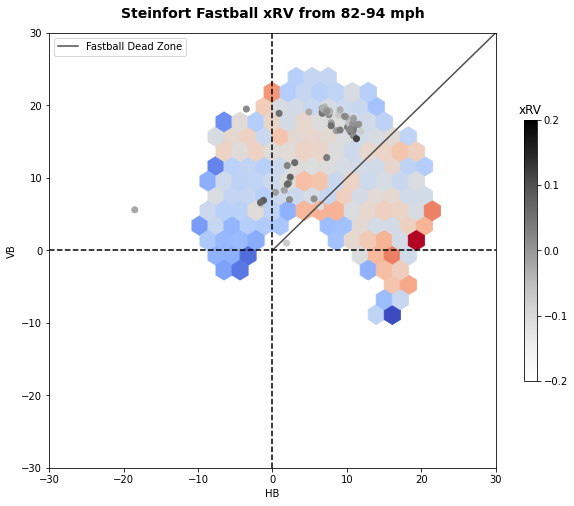

In [26]:
plt.figure(figsize = (10, 8))
plt.hexbin(fb_bucket_steinfort['pfx_x'], fb_bucket_steinfort['pfx_z'], C = fb_bucket_steinfort['xRV'], 
                cmap = 'coolwarm', mincnt = 75, gridsize = 20)
plt.plot([0, 30], [0, 30], ls="-", c=".3", label = 'Fastball Dead Zone')
cb = plt.colorbar(ticks = [-.2, -.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--'), plt.legend()
plt.title('Fastball xRV from 89-93 mph', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Fastball Avg xRunValue 89-93 mph:', round(fb_bucket_steinfort.xRV.mean(), 2))

plt.figure(figsize = (10, 8))
plt.hexbin(fb_bucket_steinfort['pfx_x'], fb_bucket_steinfort['pfx_z'], C = fb_bucket_steinfort['xRV'], 
                cmap = 'coolwarm', mincnt = 75, gridsize = 20)
plt.scatter(steinfort_fb['pfx_x'], steinfort_fb['pfx_z'], c = steinfort_fb['xRV'], cmap = 'Greys')
plt.plot([0, 30], [0, 30], ls="-", c=".3", label = 'Fastball Dead Zone')
cb = plt.colorbar(ticks = [-.2, -.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--'), plt.legend()
plt.title('Steinfort Fastball xRV from 82-94 mph', fontsize = 14, fontweight = 'bold', pad = 15);
print('Steinfort Fastball Avg xRunValue 82-94 mph:', (round(steinfort_fb.xRV.mean(), 2)))

## Breaking Ball RHP

#### Slider, Curveball, Knuckle Curve

In [27]:
print('Baseline RHP Breaking Ball RunValue Accuracy Score:', round(rhp_bb.rv.mean(), 2))

Baseline RHP Breaking Ball RunValue Accuracy Score: -0.04


In [28]:
features_bb_r = rhp_bb.select_dtypes([np.number])
X = features_bb_r.drop(columns = ['rv'])
y = features_bb_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_bb_r = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_bb_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_bb_r)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_bb_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.036
Test RMSE: 0.275
MAE: 0.158 

R2 Score: 0.633
Test RMSE: 0.164
MAE: 0.085


### RHP Breaking Ball RV

In [30]:
rhp_bb['xRV'] = pred
rhp_bb['xRV'] = round(rhp_bb['xRV'], 3)
rhp_bb['SL_count'] = [1 if x == 'SL' else 0 for x in rhp_bb['pitch_type']]
rhp_bb['CU_count'] = [1 if x == 'CU' else 0 for x in rhp_bb['pitch_type']]
rhp_bb['KC_count'] = [1 if x == 'KC' else 0 for x in rhp_bb['pitch_type']]

bb_bucket_feldman = rhp_bb.loc[(rhp_bb['velo'] >= 70) & (rhp_bb['velo'] <= 83)]
bb_bucket_steinfort = rhp_bb.loc[(rhp_bb['velo'] >= 63) & (rhp_bb['velo'] <= 71)]

rhp_bb.xRV.describe()

count    152378.000000
mean         -0.038699
std           0.154336
min          -1.124000
25%          -0.076000
50%          -0.031000
75%           0.007000
max           2.367000
Name: xRV, dtype: float64

In [31]:
features_feldman_bb = feldman_bb.select_dtypes([np.number])
pred_feldman_bb = rf.predict(features_feldman_bb)
feldman_bb['xRV'] = pred_feldman_bb

print(feldman_bb.shape)
feldman_bb.sort_values(by = 'xRV').head()

(20, 8)


,pitch_type,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,xRV
17,Slider,80.9,2829.7,-5.2,-4.3,1.8,4.6,-0.16769
11,Slider,81.5,2860.2,-7.4,-5.7,1.8,4.7,-0.16099
21,Slider,80.8,2808.1,-6.5,-5.4,1.7,4.7,-0.15391
55,Slider,80.7,2846.2,-6.5,-5.9,1.5,4.8,-0.13594
49,Slider,81.3,2801.6,-3.7,-5.6,1.7,4.8,-0.12848


In [32]:
feldman_bb.velo.min(), feldman_bb.velo.max()

(70.8, 82.8)

In [33]:
feldman_bb.describe()

,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,xRV
count,20.000000,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000
mean,78.935000,2700.370000,-5.485000,-7.620000,1.57500,4.855000,-0.023443
std,3.220375,163.915046,1.903535,4.018064,0.21734,0.203845,0.089098
min,70.800000,2416.100000,-8.100000,-15.600000,1.20000,4.600000,-0.167690
25%,77.050000,2506.775000,-7.200000,-11.825000,1.40000,4.700000,-0.111972
50%,79.850000,2791.200000,-5.950000,-6.150000,1.70000,4.800000,0.002520
75%,81.000000,2816.925000,-3.775000,-5.550000,1.80000,5.025000,0.037415
max,82.800000,2886.000000,-2.100000,-1.000000,1.80000,5.200000,0.090950


In [34]:
features_steinfort_bb = steinfort_bb.select_dtypes([np.number])
pred_steinfort_bb = rf.predict(features_steinfort_bb)
steinfort_bb['xRV'] = pred_steinfort_bb
print(steinfort_bb.shape)
steinfort_bb.sort_values(by = 'xRV').head()

(16, 8)


,pitch_type,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,xRV
56,CurveBall,69.72,2255.1,-5.4,-18.7,1.00,5.91,-0.07391
31,CurveBall,69.50,2251.3,-3.9,-21.7,0.79,5.89,-0.06765
63,CurveBall,71.54,2388.3,-7.5,-17.3,1.01,6.07,-0.05818
81,CurveBall,68.03,2125.8,-5.5,-21.3,0.97,6.12,-0.03148
73,CurveBall,69.17,2170.0,-6.4,-10.2,1.33,5.43,-0.02526


In [35]:
steinfort_bb.velo.min(), steinfort_bb.velo.max()

(63.54, 71.6)

In [36]:
steinfort_bb.describe()

,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,xRV
count,16.00000,16.00000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,69.96250,2303.72500,-4.243750,-19.325000,0.931875,5.918125,0.003916
std,1.95135,206.46308,1.776126,3.293529,0.141243,0.185408,0.058692
min,63.54000,2125.80000,-7.500000,-22.000000,0.790000,5.430000,-0.073910
25%,69.66500,2214.40000,-5.100000,-21.375000,0.835000,5.852500,-0.026815
50%,70.60500,2279.70000,-4.350000,-20.850000,0.890000,5.925000,-0.005280
75%,70.91000,2308.42500,-3.750000,-18.625000,1.002500,6.010000,0.024355
max,71.60000,3027.20000,0.400000,-10.200000,1.330000,6.200000,0.135490


### RHP Breaking Ball xRV by HB & VB

RHP Breaking Ball Avg xRunValue: -0.04


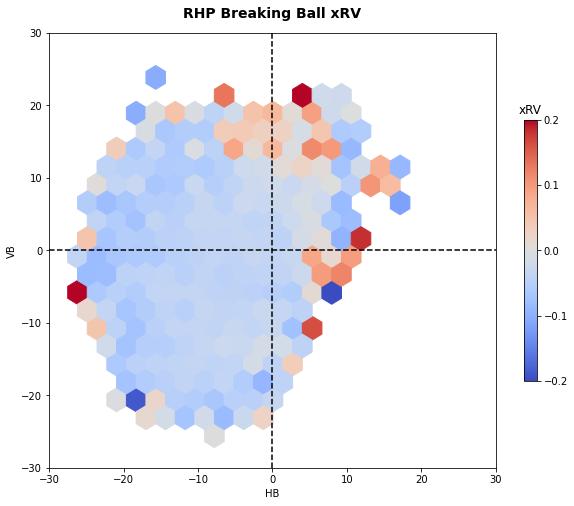

In [37]:
plt.figure(figsize = (10, 8))

ax = plt.hexbin(rhp_bb['pfx_x'], rhp_bb['pfx_z'], C = rhp_bb['xRV'], cmap = 'coolwarm', mincnt = 1, gridsize = 20)
cb = plt.colorbar(ax, ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Breaking Ball xRV', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Breaking Ball Avg xRunValue:', round(rhp_bb.xRV.mean(), 2))

### Feldman Breaking Ball

RHP Breaking Ball Avg xRunValue 70-83 mph: -0.04
Feldman Breaking Ball Avg xRunValue 89-93 mph: -0.02


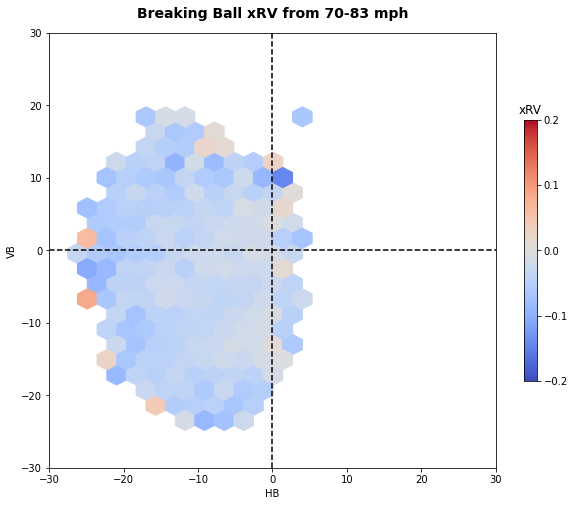

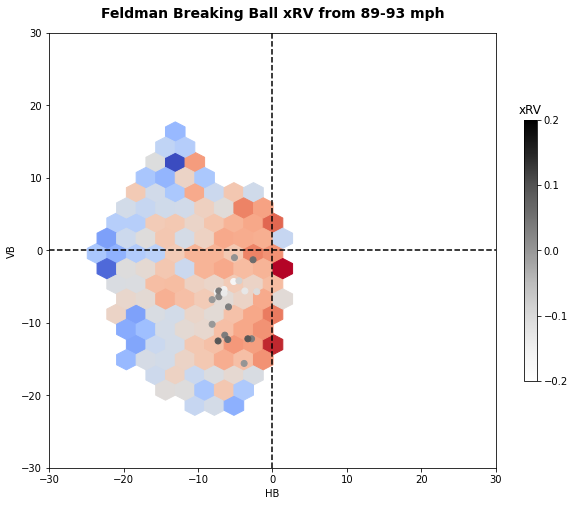

In [38]:
plt.figure(figsize = (10, 8))
plt.hexbin(bb_bucket_feldman['pfx_x'], bb_bucket_feldman['pfx_z'], C = bb_bucket_feldman['xRV'], 
                cmap = 'coolwarm', mincnt = 5, gridsize = 20)
cb = plt.colorbar(ticks = [-.2, -.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('Breaking Ball xRV from 70-83 mph', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Breaking Ball Avg xRunValue 70-83 mph:', round(bb_bucket_feldman.xRV.mean(), 2))

plt.figure(figsize = (10, 8))
plt.hexbin(bb_bucket_feldman['pfx_x'], bb_bucket_feldman['pfx_z'], C = bb_bucket_feldman['xRV'], 
                cmap = 'coolwarm', mincnt = 75, gridsize = 20)
plt.scatter(feldman_bb['pfx_x'],feldman_bb['pfx_z'], c = feldman_bb['xRV'], cmap = 'Greys')
cb = plt.colorbar(ticks = [-.2, -.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('Feldman Breaking Ball xRV from 89-93 mph', fontsize = 14, fontweight = 'bold', pad = 15);
print('Feldman Breaking Ball Avg xRunValue 89-93 mph:', (round(feldman_bb.xRV.mean(), 2)))

### Steinfort Breaking Ball

RHP Breaking Ball Avg xRunValue 63-72 mph: -0.04
Steinfort Breaking Ball Avg xRunValue 63-72 mph: 0.0


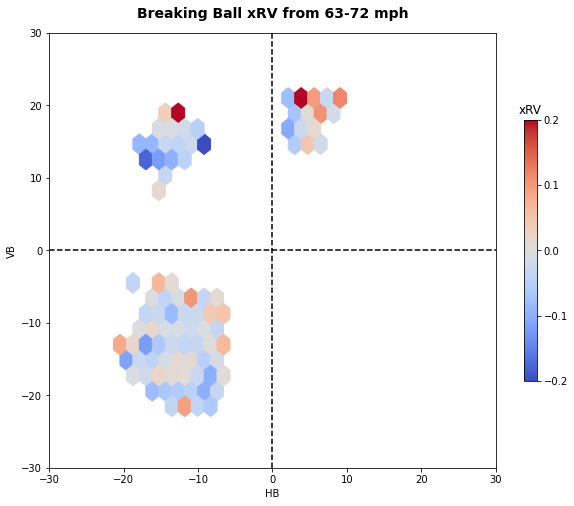

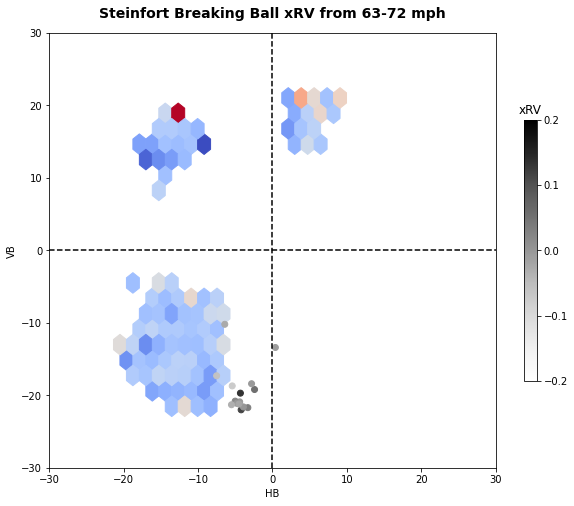

In [39]:
plt.figure(figsize = (10, 8))
plt.hexbin(bb_bucket_steinfort['pfx_x'], bb_bucket_steinfort['pfx_z'], C = bb_bucket_steinfort['xRV'], 
                cmap = 'coolwarm', mincnt = 2, gridsize = 20)
cb = plt.colorbar(ticks = [-.2, -.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('Breaking Ball xRV from 63-72 mph', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Breaking Ball Avg xRunValue 63-72 mph:', round(bb_bucket_feldman.xRV.mean(), 2))

plt.figure(figsize = (10, 8))
plt.hexbin(bb_bucket_steinfort['pfx_x'], bb_bucket_steinfort['pfx_z'], C = bb_bucket_steinfort['xRV'], 
                cmap = 'coolwarm', mincnt = 2, gridsize = 20)
plt.scatter(steinfort_bb['pfx_x'],steinfort_bb['pfx_z'], c = steinfort_bb['xRV'], cmap = 'Greys')
cb = plt.colorbar(ticks = [-.2, -.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('Steinfort Breaking Ball xRV from 63-72 mph', fontsize = 14, fontweight = 'bold', pad = 15);
print('Steinfort Breaking Ball Avg xRunValue 63-72 mph:', abs(round(steinfort_bb.xRV.mean(), 2)))

## Off-Speed RHP

#### Changeup, Splitter

In [40]:
print('Baseline RHP Off-Speed RunValue Accuracy Score:', round(rhp_os.rv.mean(), 2))

Baseline RHP Off-Speed RunValue Accuracy Score: -0.04


In [41]:
features_os_r = rhp_os.select_dtypes([np.number])
X = features_os_r.drop(columns = ['rv'])
y = features_os_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_os_r = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Score:', round((metrics.r2_score(y_test, pred_os_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_os_r)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_os_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Score: -0.045
Test RMSE: 0.283
Test MAE: 0.167 

R2 Score: 0.63
RMSE: 0.169
MAE: 0.089


### RHP OS RV

In [42]:
rhp_os['xRV'] = pred
rhp_os['xRV'] = round(rhp_os['xRV'], 3)
rhp_os['SL_count'] = [1 if x == 'CH' else 0 for x in rhp_os['pitch_type']]
rhp_os['CU_count'] = [1 if x == 'FS' else 0 for x in rhp_os['pitch_type']]

os_bucket_feldman = rhp_os.loc[(rhp_os['velo'] >= 80) & (rhp_os['velo'] <= 84)]
os_bucket_steinfort = rhp_os.loc[(rhp_os['velo'] >= 78) & (rhp_os['velo'] <= 84)]

rhp_os.xRV.describe()

count    60891.000000
mean        -0.034322
std          0.157655
min         -1.136000
25%         -0.079000
50%         -0.029000
75%          0.013000
max          2.242000
Name: xRV, dtype: float64

In [43]:
features_feldman_os = feldman_os.select_dtypes([np.number])
pred_feldman_os = rf.predict(features_feldman_os)
feldman_os['xRV'] = pred_feldman_os

print(feldman_os.shape)
feldman_os.sort_values(by = 'xRV').head()

(11, 8)


,pitch_type,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,xRV
13,ChangeUp,81.8,1527.4,15.5,10.8,2.0,4.6,-0.08074
62,ChangeUp,81.3,1949.8,11.8,15.1,1.5,4.8,-0.05245
28,ChangeUp,82.2,1555.3,12.4,10.9,1.7,4.9,-0.04160
24,ChangeUp,82.4,1538.7,11.5,12.6,1.9,4.8,-0.02736
22,ChangeUp,83.2,1563.6,11.9,10.2,1.7,4.8,-0.02673


In [44]:
feldman_os.velo.min(), feldman_os.velo.max()

(80.1, 83.2)

In [45]:
feldman_os.describe()

,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,xRV
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,81.754545,1559.800000,11.600000,11.554545,1.700000,4.827273,-0.007298
std,0.874487,135.199349,1.451895,1.560361,0.161245,0.100905,0.041075
min,80.100000,1429.100000,10.200000,10.000000,1.500000,4.600000,-0.080740
25%,81.250000,1518.450000,10.650000,10.350000,1.600000,4.800000,-0.034480
50%,81.800000,1536.600000,11.200000,10.900000,1.700000,4.800000,0.000400
75%,82.300000,1550.550000,11.850000,12.450000,1.800000,4.900000,0.024340
max,83.200000,1949.800000,15.500000,15.100000,2.000000,5.000000,0.050790


In [46]:
features_steinfort_os = steinfort_os.select_dtypes([np.number])
pred_steinfort_os = rf.predict(features_steinfort_os)
steinfort_os['xRV'] = pred_steinfort_os

print(steinfort_os.shape)
steinfort_os.head()

(11, 8)


,pitch_type,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,xRV
23,Splitter,83.15,906.8,7.5,10.4,1.17,5.71,-0.17100
32,Splitter,82.83,924.4,8.1,10.7,1.20,5.70,-0.10663
38,Splitter,82.51,879.3,7.6,9.5,1.18,5.98,-0.07397
43,Splitter,82.98,1053.1,9.9,10.7,1.31,5.85,-0.05066
51,Splitter,81.46,801.2,10.2,7.0,1.38,5.84,0.01542


In [47]:
steinfort_os.velo.min(), steinfort_os.velo.max()

(78.68, 83.15)

In [48]:
steinfort_os.describe()

,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,xRV
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,81.520909,966.445455,9.381818,9.027273,1.300909,5.879091,-0.036459
std,1.434318,174.547995,1.185595,2.090020,0.100045,0.104447,0.080994
min,78.680000,665.100000,7.500000,5.600000,1.170000,5.700000,-0.171000
25%,80.825000,885.200000,8.500000,7.350000,1.205000,5.835000,-0.088545
50%,81.460000,924.400000,9.700000,9.500000,1.310000,5.910000,-0.050660
75%,82.690000,1105.250000,10.200000,10.700000,1.375000,5.950000,0.031450
max,83.150000,1238.300000,11.000000,12.000000,1.480000,6.020000,0.095750


### RHP Off-Speed xRV by HB & VB

RHP Off-Speed Avg xRunValue: -0.04


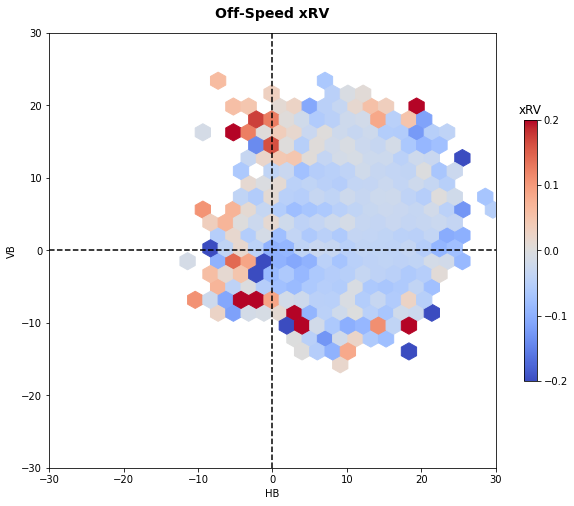

In [49]:
plt.figure(figsize = (10, 8))
plt.hexbin(rhp_os['pfx_x'], rhp_os['pfx_z'], C = rhp_os['xRV'], cmap = 'coolwarm', mincnt = 0, gridsize = 20)
cb = plt.colorbar(ticks = [-.2, -.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('Off-Speed xRV', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Off-Speed Avg xRunValue:', round(bb_bucket_feldman.xRV.mean(), 2))

### Feldman Off-Speed

RHP Off-Speed Avg xRunValue 80-84 mph: -0.04
Feldman Off-Speed Avg xRunValue 80-84 mph: -0.02


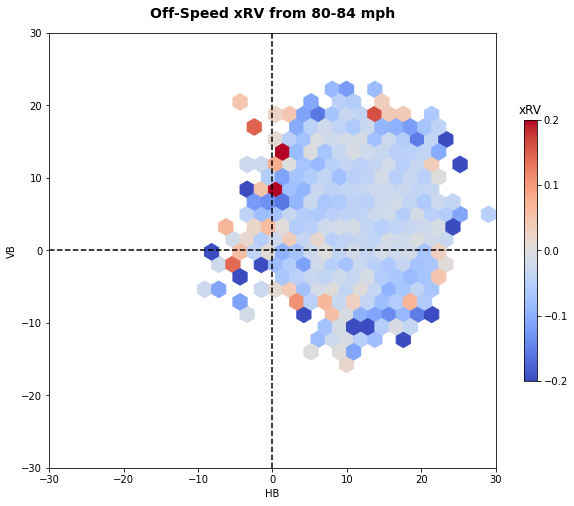

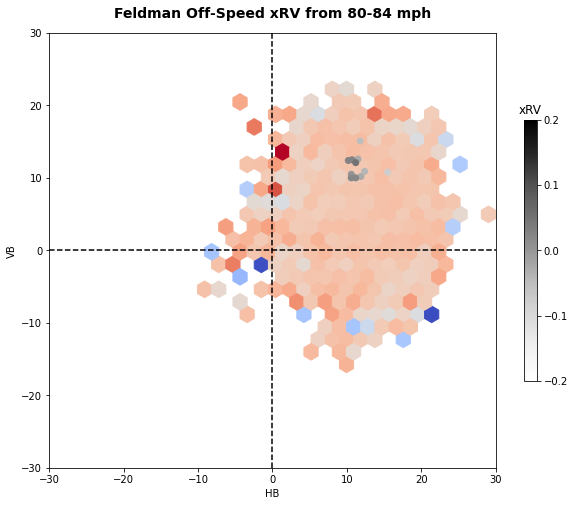

In [50]:
plt.figure(figsize = (10, 8))
plt.hexbin(os_bucket_feldman['pfx_x'], os_bucket_feldman['pfx_z'], C = os_bucket_feldman['xRV'], 
                cmap = 'coolwarm', mincnt = 0, gridsize = 20)
cb = plt.colorbar(ticks = [-.2, -.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('Off-Speed xRV from 80-84 mph', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Off-Speed Avg xRunValue 80-84 mph:', round(bb_bucket_feldman.xRV.mean(), 2))

plt.figure(figsize = (10, 8))
plt.hexbin(os_bucket_feldman['pfx_x'], os_bucket_feldman['pfx_z'], C = os_bucket_feldman['xRV'], 
                cmap = 'coolwarm', mincnt = 0, gridsize = 20)
plt.scatter(feldman_os['pfx_x'], feldman_os['pfx_z'], c = feldman_os['xRV'], cmap = 'Greys')
cb = plt.colorbar(ticks = [-.2, -.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('Feldman Off-Speed xRV from 80-84 mph', fontsize = 14, fontweight = 'bold', pad = 15);
print('Feldman Off-Speed Avg xRunValue 80-84 mph:', (round(feldman_bb.xRV.mean(), 2)))

### Steinfort Off-Speed

RHP Off-Speed Avg xRunValue 80-84 mph: -0.03
Steinfort Off-Speed Avg xRunValue 80-84 mph: -0.04


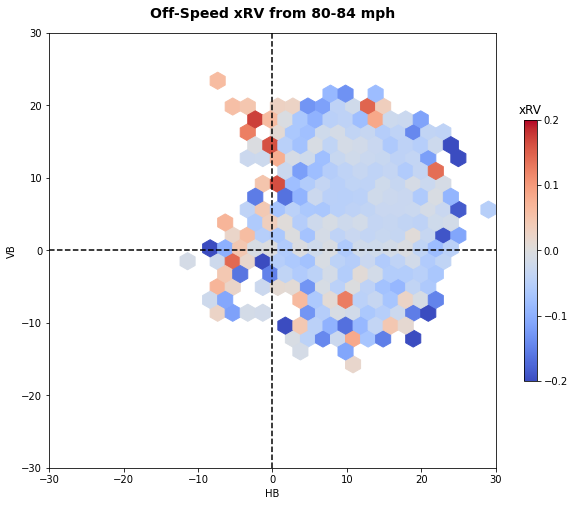

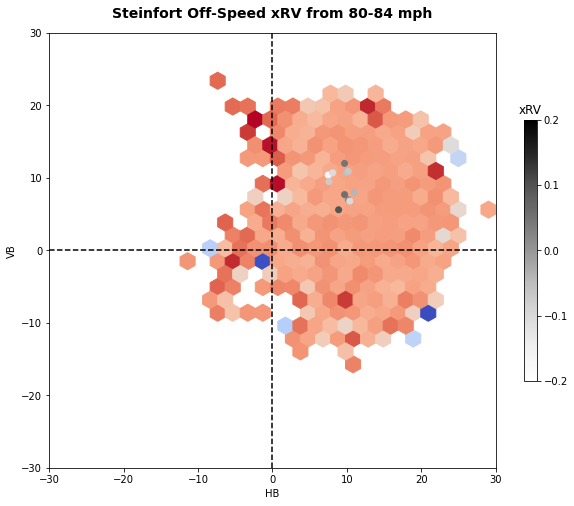

In [51]:
plt.figure(figsize = (10, 8))
plt.hexbin(os_bucket_steinfort['pfx_x'], os_bucket_steinfort['pfx_z'], C = os_bucket_steinfort['xRV'], 
                cmap = 'coolwarm', mincnt = 0, gridsize = 20)
cb = plt.colorbar(ticks = [-.2, -.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('Off-Speed xRV from 80-84 mph', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Off-Speed Avg xRunValue 80-84 mph:', round(os_bucket_steinfort.xRV.mean(), 2))

plt.figure(figsize = (10, 8))
plt.hexbin(os_bucket_steinfort['pfx_x'], os_bucket_steinfort['pfx_z'], C = os_bucket_steinfort['xRV'], 
                cmap = 'coolwarm', mincnt = 0, gridsize = 20)
plt.scatter(steinfort_os['pfx_x'], steinfort_os['pfx_z'], c = steinfort_os['xRV'], cmap = 'Greys')
cb = plt.colorbar(ticks = [-.2, -.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('Steinfort Off-Speed xRV from 80-84 mph', fontsize = 14, fontweight = 'bold', pad = 15);
print('Steinfort Off-Speed Avg xRunValue 80-84 mph:', (round(steinfort_os.xRV.mean(), 2)))